In [1]:
import pickle
import pandas as pd
import numpy as np
import nrrd
import seaborn as sns

import umap
import umap.plot
import networkx as nx
import sys
sys.path.insert(1, '../scripts_other/')
import cs_umap_plot

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output

import os

import time
import datetime

print(datetime.datetime.now())

2023-08-08 13:18:26.007545


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_patient = '../metadata/Celine_FINAL_RADIOPOP_DATA_with LRE Death_220729.xlsx'
fn_healthy = '../metadata/healthy4grouping.csv'
path_features = path_data + 'features/'

# OUTPUTS
path_umapPlots = '../figures/umapFigures_20220720/'
fn_metacsv = path_data + 'metadata_all.csv'
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_rawFeat_csv = path_data + 'csv_rawFeatures_s20220720.csv'

fn_f_umap_norm1 = '../figures/f_umap_norm1_s20220720.png'
fn_f_umap_norm1a = '../figures/f_umap_norm1_s20220720.svg'
fn_f_umap_norm2 = '../figures/f_umap_norm2_s20220720.png'
fn_f_umap_batch1 = '../figures/f_umap_batch1_s20220720.svg'
fn_f_umap_batch2 = '../figures/f_umap_batch2_s20220720.png'


fn_f_umap_thumb = '../figures/f_umap_thumb_s20220720.svg'

# supplmentary outputs
fn_finalSave_supp = '../supplementaryFiles/featuresAndMeta_s20220720.p'
fn_rawFeat_csv_supp = '../supplementaryFiles/csv_rawFeatures_s20220720.csv'
fn_metadata_supp = '../supplementaryFiles/csv_metadata_s20220720.csv'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

try:
    os.mkdir(path_umapPlots)
except OSError:
    print ("Creation of the directory %s failed" % path_umapPlots)
else:
    print ("Successfully created the directory %s " % path_umapPlots)

Creation of the directory ../figures/umapFigures_20220720/ failed


In [3]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

In [4]:
test = pd.read_excel(fn_patient, index_col=0, dtype=str)

In [5]:
print(test.columns)

Index(['Training = 0, Testing = 1', 'age at CT', 'BL = CT-Datum', 'SEX',
       'DATEDIF BL CT', 'DATEDIF HVPG CT', 'HVPG-DATE STUDIE',
       'New BL = CT date', 'CT machine group', 'ID.1',
       ...
       'ExclusionNOHVPG_0;1', 'ExclusionNoFU01', 'InclusionFVIIIPC_0;1',
       'InclusionVWF_01', 'cACLDTimeDecompLiverRelDeathwithin360days',
       'cACLDStatusDecompLiverRelDeathwithin360days',
       'cACLDTimeDecompLiverRelDeath>360days',
       'cACLDStatusDecompLiverRelDeath>360',
       'TimeDecompLiverRelDeathwithCensoring360',
       'StatusDecompLiverRelDeathwithCensoring360'],
      dtype='object', length=659)


In [6]:
patients_df = pd.read_excel(fn_patient, index_col=0, dtype=str)#, index_col=0, header=1, nrows=371, dtype=str)
patients_df['patientID'] = patients_df.index
patients_df['patientID'] = patients_df['patientID'].apply(lambda x: str(x).zfill(4))
patients_df = patients_df.set_index('patientID')

patients_df = patients_df[['Training = 0, Testing = 1',
                           'age at CT',
                           'SEX',
                           'CT machine group',
                           'LRE duration (months) from CT',
                           'LRE FU yes (1) no (0)',
                           'decomp at BL yes(1) no (0)', #
                           'LRD duration (months) from CT',
                           'LRD yes (1) no (0)', #
                           'overall survival duration (months) from CT',
                           'overall survival yes (1) no (0)', #
                           'TFS-liver related duration (months) from CT', #
                           'TFS-liver related_status 01', #
                           'BL_HVPG_corrected (ohne Kollat., inkor. Messungen)',
                           'BL_HVPG_0=0-5;1=6-9;2=10-15;3=>=16;99=unknown/invalid',
                           'Decompensated_0=BAVENO1_012;1=BAVENO1_345',
                           'HepDecomp or LRD_time (months)',
                           'HepDecomp or LRD mit Zensierungsvariable_time_180days (months)',
                           'HepDecomp or LRD mit Zensierungsvariable_time_360days (months)',
                           'BL-CPS_calc_w_INR',
                           'BL-CPSscore_INR_cat_123',
                           'BL-MELD_UNOS_2016',
                           'BL-MELD_UNOS_0=<10;1=10-15;2=>15',
                           'ETIOcoded 1=ALD, 2=NAFLD, 3=Viral, 4=Other, 5=Unknown',
                           'Na', 'Krea', 'Alb', 'CRP', 'INR', 'Bili']]
# cleaning
col_dict = {'Training = 0, Testing = 1': 'trainTest',
            'age at CT': 'age',
            'SEX': 'sex',
            'CT machine group': 'ct_grp',
            'LRE duration (months) from CT': 'lre',
            'LRE FU yes (1) no (0)': 'lre_tf',
            'decomp at BL yes(1) no (0)': 'decompBL',
            'LRD duration (months) from CT': 'lrd',
            'LRD yes (1) no (0)': 'lrd_tf',
            'overall survival duration (months) from CT': 'survival',
            'overall survival yes (1) no (0)': 'survival_tf',
            'TFS-liver related duration (months) from CT': 'tfs',
            'TFS-liver related_status 01': 'tfs_tf',
            'BL_HVPG_corrected (ohne Kollat., inkor. Messungen)': 'hvpg_corrected',
            'BL_HVPG_0=0-5;1=6-9;2=10-15;3=>=16;99=unknown/invalid': 'hvpg_grp',
            'Decompensated_0=BAVENO1_012;1=BAVENO1_345': 'decompensated_acld',
            'HepDecomp or LRD_time (months)': 'hepLrd_time',
            'HepDecomp or LRD mit Zensierungsvariable_time_180days (months)': 'hepLrd_180',
            'HepDecomp or LRD mit Zensierungsvariable_time_360days (months)': 'hepLrd_360',
            'BL-CPS_calc_w_INR': 'cps',
            'BL-CPSscore_INR_cat_123': 'cps_grp',
            'BL-MELD_UNOS_2016': 'meld',
            'BL-MELD_UNOS_0=<10;1=10-15;2=>15': 'meld_grp',
            'ETIOcoded 1=ALD, 2=NAFLD, 3=Viral, 4=Other, 5=Unknown': 'etiology',
            'Na': 'sodium', 
            'Krea': 'creatinine', 
            'Alb': 'albumin', 
            'CRP': 'CRP',
            'INR': 'INR',
            'Bili': 'bilirubin'}

patients_df = patients_df.rename(columns=col_dict)

In [7]:
patients_df['age'] = pd.to_numeric(patients_df['age'])

temp_dict = {'M': '1', '1 dicom': '1', 0: '0'}
patients_df['sex'] = patients_df['sex'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
patients_df['sex'] = patients_df['sex'].astype('str')
patients_df['ct_grp'] = patients_df['ct_grp'].astype('str')

patients_df['lre'] = pd.to_numeric(patients_df['lre'])
patients_df['lrd'] = pd.to_numeric(patients_df['lrd'])
patients_df['survival'] = pd.to_numeric(patients_df['survival'])
patients_df['tfs'] = pd.to_numeric(patients_df['tfs'])

temp_dict = {'1': True, '0': False}
patients_df['lre_tf'] = patients_df['lre_tf'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
patients_df['decompBL'] = patients_df['decompBL'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
patients_df['lrd_tf'] = patients_df['lrd_tf'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
patients_df['survival_tf'] = patients_df['survival_tf'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
patients_df['tfs_tf'] = patients_df['tfs_tf'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)

patients_df['hvpg_corrected'] = pd.to_numeric(patients_df['hvpg_corrected'])
patients_df['hvpg_grp'] = patients_df['hvpg_grp'].astype('str')

patients_df['hepLrd_time'] = pd.to_numeric(patients_df['hepLrd_time'])
patients_df['hepLrd_180'] = pd.to_numeric(patients_df['hepLrd_180'])
patients_df['hepLrd_360'] = pd.to_numeric(patients_df['hepLrd_360'])
patients_df['cps'] = pd.to_numeric(patients_df['cps'])
patients_df['cps_grp'] = patients_df['cps_grp'].astype('str')
patients_df['meld'] = pd.to_numeric(patients_df['meld'])
patients_df['meld_grp'] = patients_df['meld_grp'].astype('str')

patients_df['sodium'] = pd.to_numeric(patients_df['sodium'])
patients_df['creatinine'] = pd.to_numeric(patients_df['creatinine'])
patients_df['albumin'] = pd.to_numeric(patients_df['albumin'])
patients_df['CRP'] = pd.to_numeric(patients_df['CRP'])
patients_df['INR'] = pd.to_numeric(patients_df['INR'])
patients_df['bilirubin'] = pd.to_numeric(patients_df['bilirubin'])

patients_df['cntl_grp'] = 0

patients_df.dtypes

trainTest              object
age                     int64
sex                    object
ct_grp                 object
lre                   float64
lre_tf                   bool
decompBL                 bool
lrd                   float64
lrd_tf                   bool
survival              float64
survival_tf              bool
tfs                   float64
tfs_tf                   bool
hvpg_corrected        float64
hvpg_grp               object
decompensated_acld     object
hepLrd_time           float64
hepLrd_180            float64
hepLrd_360            float64
cps                     int64
cps_grp                object
meld                    int64
meld_grp               object
etiology               object
sodium                  int64
creatinine            float64
albumin               float64
CRP                   float64
INR                   float64
bilirubin             float64
cntl_grp                int64
dtype: object

In [ ]:
# check for data integrity
# print(patients_df.index[patients_df['trainTest'].str.isnumeric()==False])
# print(patients_df.index[patients_df['age'].str.isnumeric()==False])
# print(patients_df.index[patients_df['sex'].str.isnumeric()==False])
# print(patients_df.index[patients_df['ct_grp'].str.isnumeric()==False])
# print(patients_df.index[patients_df['lre'].str.isnumeric()==False])
# print(patients_df.index[patients_df['lrd'].str.isnumeric()==False])
# print(patients_df.index[patients_df['survival'].str.isnumeric()==False])
# print(patients_df.index[patients_df['hvpg_corrected'].str.isnumeric()==False])
# print(patients_df.index[patients_df['hvpg_grp'].str.isnumeric()==False])
# print(patients_df.index[patients_df['hepLrd_time'].str.isnumeric()==False])
# print(patients_df.index[patients_df['hepLrd_180'].str.isnumeric()==False])
# print(patients_df.index[patients_df['hepLrd_360'].str.isnumeric()==False])
# print(patients_df.index[patients_df['cps'].str.isnumeric()==False])
# print(patients_df.index[patients_df['cps_grp'].str.isnumeric()==False])
# print(patients_df.index[patients_df['meld'].str.isnumeric()==False])
# print(patients_df.index[patients_df['meld_grp'].str.isnumeric()==False])
#patients_df

In [ ]:
healthy_df = pd.read_csv(fn_healthy, index_col=0)
healthy_df.index = healthy_df.index.astype(str)
healthy_df['trainTest'] = healthy_df['trainTest'].astype('str')
healthy_df['sex'] = healthy_df['sex'].astype('str')
healthy_df['ct_grp'] = healthy_df['ct_grp'].astype('str')
healthy_df['cntl_grp'] = 1

#healthy_df

In [10]:
# # Includes all patients including healthy controls (these are all patients with an ID > 1000)
# healthy_df = pd.read_excel(fn_patient2, dtype=str)#, index_col=0, header=1, nrows=371, dtype=str)
# healthy_df['patientID'] = healthy_df['ID'].str[:4]
# healthy_df['patientID'] = pd.to_numeric(healthy_df['patientID'], errors='coerce')
# healthy_df = healthy_df[healthy_df['patientID'] >= 1000]
# healthy_df.index = healthy_df['patientID'].astype(str)
# healthy_df = healthy_df[['age at CT', 'SEX', 'training (0) testing (1)', 'CT machine group']]

# # cleaning
# col_dict = {'training (0) testing (1)': 'trainTest',
#             'age at CT': 'age',
#             'SEX': 'sex',
#             'CT machine group': 'ct_grp'}
# healthy_df = healthy_df.rename(columns=col_dict)


# temp_dict = {'M': '0', '1 dicom': '1', 0: '0'}
# healthy_df['sex'] = healthy_df['sex'].apply(lambda x: temp_dict[x] if x in temp_dict.keys() else x)
# healthy_df['age'] = pd.to_numeric(healthy_df['age'])

# healthy_df

In [ ]:
allPatients_df = pd.concat([patients_df, healthy_df])
allPatients_df['patientID'] = allPatients_df.index
allPatients_df.index.name = None
#allPatients_df

In [12]:
# write patients_df to csv
toWrite = allPatients_df.drop(columns='patientID')
toWrite.to_csv(fn_metacsv)

## raw features dataframe

In [13]:
currDataPath = path_features

# massage features
df_rawFeatures = pd.DataFrame()

list_patients = list(patients_df.index) + list(healthy_df.index)

for eaPatient in list_patients:
    currPath = currDataPath + str(eaPatient) + '.p'
    with open(currPath, "rb") as input_file:
         e = pickle.load(input_file)
    # turn into df
    tempdf = pd.DataFrame.from_dict(e)
    # keep rows starting with original (features)
    rows2keep = [s for s in tempdf.index if not s.startswith('diagnostics')]
    tempdf = tempdf[tempdf.index.isin(rows2keep)]
    # melt columns (liver,spleen) into feature space
    tempdf['feature']=tempdf.index + '_'
    df_melted = pd.melt(tempdf,id_vars=['feature'],value_vars=["liver","spleen"])
    df_melted['feature'] = df_melted['feature'] + df_melted['variable']
    df_melted = df_melted.drop(columns='variable')
    df_melted = df_melted.set_index('feature')
    # rename column to patient ID
    currID = eaPatient
    #currID = eaFile.split('features')[1].split('.')[0].zfill(4)
    #currID = eaFile.split('.')[0].zfill(4)
    df_melted = df_melted.rename(columns={"value": currID})
    df_rawFeatures = df_rawFeatures.join(df_melted, how='outer')

df_rawFeatures = df_rawFeatures.T.sort_index()
df_rawFeatures

feature,original_shape_Elongation_liver,original_shape_Flatness_liver,original_shape_LeastAxisLength_liver,original_shape_MajorAxisLength_liver,original_shape_Maximum2DDiameterColumn_liver,original_shape_Maximum2DDiameterRow_liver,original_shape_Maximum2DDiameterSlice_liver,original_shape_Maximum3DDiameter_liver,original_shape_MeshVolume_liver,original_shape_MinorAxisLength_liver,...,wavelet-LLL_gldm_GrayLevelNonUniformity_spleen,wavelet-LLL_gldm_GrayLevelVariance_spleen,wavelet-LLL_gldm_HighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen
0001,0.465075,0.339181,71.588041,211.061515,138.2931668593933,189.88944151795275,198.33809518093088,235.4293949361464,739649.25,98.159336,...,127575.80853568878,15.794225056167972,2294.977036658146,32.3712477793447,74900.36632701651,0.014209721380891261,0.0004511630488611161,0.115594447798043,251.97194898082324,5.949732731233634e-05
0002,0.60609,0.339005,74.300134,219.171282,212.17445652104308,180.42727066604982,243.11519903124116,269.04646438858845,1139264.75,132.837457,...,16028.012887548719,24.523607522107344,2347.9454424431005,18.522511107190404,44525.21705936132,0.007887027517488663,0.0004520243804644806,0.19723531630885857,431.776073838238,0.00010461835204424011
0004,0.655077,0.497711,105.952152,212.878878,229.88910370002316,188.939143641544,221.16283593768642,247.3095226634025,1628414.0,139.452089,...,20038.941331088765,15.421438229101831,826.3691984524285,19.878815398927923,16525.871730976534,0.025215015680054173,0.0013178760895301855,0.17214087141082507,140.12136906012532,0.00024746400819043767
0005,0.724457,0.574053,103.539504,180.365832,217.27862297059966,173.6663467687393,197.39554199626699,225.97787502319778,1249523.0,130.667301,...,13318.697927804084,48.97367353651029,1316.6946353715866,24.86300765405699,36075.917052763776,0.018657277332812777,0.0009859332942524749,0.17541323886550608,181.49193974975483,0.0002779644801289994
0006,0.631016,0.521847,108.890476,208.663762,227.37853900489378,191.67159413955946,200.6888138387389,249.75588081164375,1570766.0833333333,131.670147,...,42326.31137268583,21.09499979419764,2093.5119788399547,18.981188088920497,40216.536419564654,0.009166899082882289,0.0005065800648369636,0.1863416790912313,372.0348644162567,0.00010932210677159434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.628573,0.426179,106.033095,248.799643,290.6303494131334,200.42205467462907,284.7823730500187,299.56468416687574,2026829.4583333333,156.388746,...,13737.682412567092,26.88752306934084,1488.6655413490137,13.934660353492188,21132.380687839734,0.009624554580163218,0.0007419901681440474,0.24232149532662184,345.06708701299107,0.00020891658555191847
1139,0.600549,0.457621,106.580987,232.902397,269.60155785900054,174.89711261195822,241.42286552851616,271.16415692344003,1898839.0416666667,139.869367,...,15353.438868551055,30.843193828433957,1363.0512207237246,15.19878608075557,20708.924310365946,0.011987860769732466,0.0008203011495615378,0.22170134692719015,298.1366595758098,0.00020111010364387934
1140,0.766175,0.651204,114.916458,176.467775,202.97044119772713,187.29655629509048,194.28072472584614,209.5089496895061,1485625.0833333333,135.205238,...,18423.662402835536,14.44808068334074,1172.7839965959538,22.465696338018283,26488.888776298012,0.019611752648632807,0.0009102763571771908,0.1614581693183614,181.66439369592476,0.00017125163337169017
1141,0.665362,0.478099,103.666919,216.831646,256.2225595063791,176.13914953808538,235.9194777885031,260.84861510078986,1724406.0,144.271498,...,21895.342402019887,16.359591854100266,1256.3141746691442,20.844267294571555,26349.15703059618,0

In [14]:
# get lists of training and testing, then split feature_df into two df
# training (0) testing (1)

list_training = list(allPatients_df[allPatients_df['trainTest'] == '0'].index)
list_validation = list(allPatients_df[allPatients_df['trainTest'] == '1'].index)

## save for local use
df_rawFeatures_train = df_rawFeatures[df_rawFeatures.index.isin(list_training)]
df_rawFeatures_validation = df_rawFeatures[df_rawFeatures.index.isin(list_validation)]

#display(df_rawFeatures_train)
print(df_rawFeatures_train.shape)
#display(df_rawFeatures_validation)
print(df_rawFeatures_validation.shape)

(453, 2436)
(109, 2436)


## normalize features: batch correction for CT machine

In [15]:
currFeatureSet = df_rawFeatures_train

df_tempFeatures = pd.DataFrame()

# for each CT scan group, zscore_mad all values
df_tempFeatures = pd.DataFrame()
for eaCTgrp in allPatients_df['ct_grp'].unique():
    currPatients = allPatients_df[allPatients_df['ct_grp']==eaCTgrp].index.tolist()
    subsetFeatures = currFeatureSet[currFeatureSet.index.isin(currPatients)]
    # znormalize with median
    temp = (subsetFeatures - subsetFeatures.median()) / abs(subsetFeatures - subsetFeatures.median()).median()
    df_tempFeatures = df_tempFeatures.append(temp)
df_zmadFeatureByGrp = df_tempFeatures.sort_index()

# for each CT scan group, zscore all values
df_tempFeatures = pd.DataFrame()
for eaCTgrp in allPatients_df['ct_grp'].unique():
    currPatients = allPatients_df[allPatients_df['ct_grp']==eaCTgrp].index.tolist()
    subsetFeatures = currFeatureSet[currFeatureSet.index.isin(currPatients)]
    # znormalize with mean
    temp = (subsetFeatures - subsetFeatures.mean()) / subsetFeatures.std()
    df_tempFeatures = df_tempFeatures.append(temp)
df_zscoreFeatureByGrp = df_tempFeatures.sort_index()

# straight zscore
df_zscoreFeaturePool = ((currFeatureSet - currFeatureSet.mean()) / currFeatureSet.std()).sort_index()

# straight zmadscore
df_zmadFeaturePool = ((currFeatureSet - currFeatureSet.median()) / abs(currFeatureSet - currFeatureSet.median()).median()).sort_index()

In [ ]:
# check that patient list same in features dataframes
print('Check that patients are same and in same order in features dataframes')
print(df_rawFeatures_train.index.equals(df_zscoreFeatureByGrp.index))
print(df_rawFeatures_train.index.equals(df_zmadFeatureByGrp.index))
print(df_rawFeatures_train.index.equals(df_zscoreFeaturePool.index))
print(df_rawFeatures_train.index.equals(df_zmadFeaturePool.index))

# translate metadata to dictionary for umap coloring
patientOrder = df_zmadFeatureByGrp.index
patientOrder

# reduce metadata to those with feature data
currMeta = pd.DataFrame()#index=df_zmadFeatureByGrp.index.copy())
currMeta['patientID'] = df_rawFeatures_train.index
currMeta = currMeta.merge(allPatients_df, on='patientID').set_index('patientID')
#display(currMeta.head())
print(len(currMeta))
print('Check that metadata patients are same and in same order in features dataframes')
print(currMeta.index.equals(df_zmadFeatureByGrp.index))

In [17]:
# prepare umap datastructure
features_training = {'data': df_rawFeatures_train.to_numpy(),
                     'data_zscoreByGrp': df_zscoreFeatureByGrp.to_numpy(),
                     'data_zmadByGrp': df_zmadFeatureByGrp.to_numpy(),
                     'data_zscorePooled': df_zscoreFeaturePool.to_numpy(),
                     'data_zmadPooled': df_zmadFeaturePool.to_numpy(),
                     'age': currMeta['age'].astype(float).to_numpy(),
                     'sex': currMeta['sex'].astype(int).to_numpy(),
                     'trainTest': currMeta['trainTest'].astype(int).to_numpy(),
                     'ct_grp': currMeta['ct_grp'].astype(int).to_numpy(),
                     'hvpg_corrected': currMeta['hvpg_corrected'].astype(float).to_numpy()}

In [18]:
# before after diagnostics, without validation set
# 1. training before normalization (colored by CT group)
# 2. training before normalization (colored by CT specific)
# 3. training after zscore normalization (colored by CT group)
# 4. training after zscore mad normalization (colored by CT group)
# 5. training after pooled zscore normalization (colored by CT group)
# 6. training after pooled zscore mad normalization (colored by CT group)

In [19]:
fit_raw = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding_raw = fit_raw.fit_transform(features_training['data'])
mapper_raw = fit_raw.fit(features_training['data'])

fit_zscore = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding_zscore = fit_zscore.fit_transform(features_training['data_zscoreByGrp'])
mapper_zscore = fit_zscore.fit(features_training['data_zscoreByGrp'])

fit2 = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding2 = fit2.fit_transform(features_training['data_zmadByGrp'])
mapper2 = fit2.fit(features_training['data_zmadByGrp'])

fit3 = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding3 = fit3.fit_transform(features_training['data_zscorePooled'])
mapper3 = fit3.fit(features_training['data_zscorePooled'])

fit4 = umap.UMAP(n_neighbors = 10,
                min_dist = 0.7)
embedding4 = fit4.fit_transform(features_training['data_zmadPooled'])
mapper4 = fit4.fit(features_training['data_zmadPooled'])

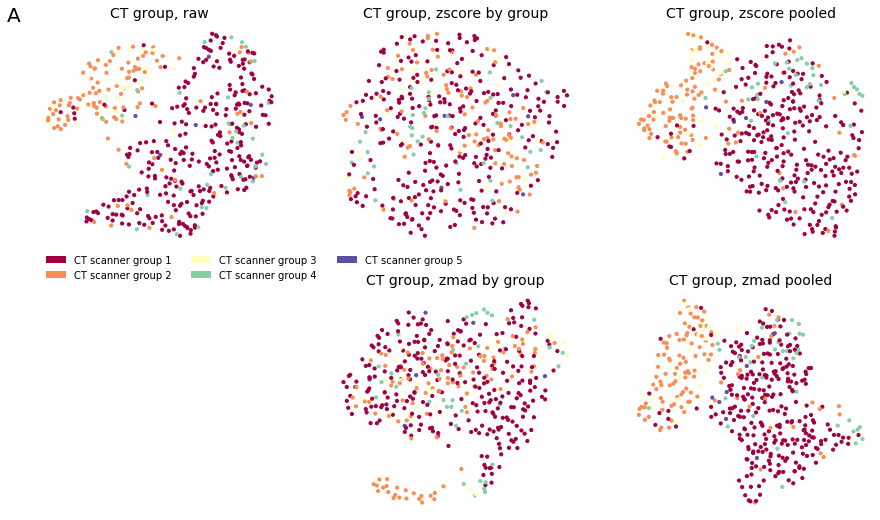

In [20]:
# PRE POST NORMALIZATION BY CT GROUP

temp = features_training['ct_grp']
temp[temp==5] = 4
temp[temp==6] = 5
features_training['ct_grp_long'] = np.array(['CT scanner group ' + str(i) for i in temp])


fig, axs = plt.subplots(2,3,figsize=(15,9))
axs[0,0] = cs_umap_plot.points(mapper_raw, labels=features_training['ct_grp_long'], point_size=10, show_legend=True, ax=axs[0,0])
axs[0,0].set_title('CT group, raw')
plt.text(-0.12, 1.01, 'A', fontsize = 20, transform=axs[0,0].transAxes)

axs[0,1] = cs_umap_plot.points(mapper_zscore, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[0,1])
axs[0,1].set_title('CT group, zscore by group')
axs[1,1] = cs_umap_plot.points(mapper2, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[1,1])
axs[1,1].set_title('CT group, zmad by group')
axs[0,2] = cs_umap_plot.points(mapper3, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[0,2])
axs[0,2].set_title('CT group, zscore pooled')
axs[1,2] = cs_umap_plot.points(mapper4, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[1,2])
axs[1,2].set_title('CT group, zmad pooled')

for i, ax in enumerate(fig.axes):
    ax.axis('off')

    
plt.savefig(fn_f_umap_norm1, bbox_inches='tight')
plt.savefig(fn_f_umap_norm1a, bbox_inches='tight')

In [21]:
# zscore by group normalization scheme looks the best, apply on to validation set
baseFeatureSet = df_rawFeatures_train  # the feature set from which we extract normalization factors
unnormedFeatureSet = df_rawFeatures_validation

# create dictionary to normalize data from features extracted from training dataset
dict_normFactors = dict()
for eaCTgrp in allPatients_df['ct_grp'].unique():
    # collect subset of patients in that CT group
    currPatients = allPatients_df[allPatients_df['ct_grp']==eaCTgrp].index.tolist()
    subsetFeatures = baseFeatureSet[baseFeatureSet.index.isin(currPatients)]
    # normalization factors
    dict_normFactors[eaCTgrp] = {'mean': subsetFeatures.mean(), 
                                 'std': subsetFeatures.std(),
                                 'median': subsetFeatures.median(),
                                 'mad': abs(subsetFeatures - subsetFeatures.median()).median()}    

# using dict_normFactors, normalize validation set
df_tempFeatures = pd.DataFrame()
for eaCTgrp in allPatients_df['ct_grp'].unique():
    # collect subset of patients in that CT group
    currPatients = allPatients_df[allPatients_df['ct_grp']==eaCTgrp].index.tolist()
    subsetFeatures = unnormedFeatureSet[unnormedFeatureSet.index.isin(currPatients)]
    # znormalize with mean
    currMean = dict_normFactors[eaCTgrp]['mean']
    currStd = dict_normFactors[eaCTgrp]['std']
    temp = (subsetFeatures - currMean) / currStd
    
    df_tempFeatures = df_tempFeatures.append(temp)
df_zscoreFeatureByGrp_validation = df_tempFeatures.sort_index()

In [22]:
# reduce metadata to those with feature data
currMeta = pd.DataFrame()#index=df_zmadFeatureByGrp.index.copy())
currMeta['patientID'] = df_rawFeatures_validation.index
currMeta = currMeta.merge(allPatients_df, on='patientID').set_index('patientID')
display(currMeta.head())
print(len(currMeta))
print('Check that metadata patients are same and in same order in features dataframes')
print(currMeta.index.equals(df_rawFeatures_validation.index))


# prepare umap datastructure
features_validation = {'data': df_rawFeatures_validation.to_numpy(),
                       'data_zscoreByGrp': df_zscoreFeatureByGrp_validation.to_numpy(),
                       'age': currMeta['age'].astype(float).to_numpy(),
                       'sex': currMeta['sex'].astype(int).to_numpy(),
                       'trainTest': currMeta['trainTest'].astype(int).to_numpy(),
                       'ct_grp': currMeta['ct_grp'].astype(int).to_numpy(),
                       'hvpg_corrected': currMeta['hvpg_corrected'].astype(float).to_numpy()}

# prepare umap datastructure
features_together = {'data': np.concatenate((features_validation['data'], features_training['data'])),
                     'data_zscoreByGrp': np.concatenate((features_validation['data_zscoreByGrp'], features_training['data_zscoreByGrp'])),
                     'age': np.concatenate((features_validation['age'], features_training['age'])),
                     'sex': np.concatenate((features_validation['sex'], features_training['sex'])),
                     'trainTest': np.concatenate((features_validation['trainTest'], features_training['trainTest'])),
                     'ct_grp': np.concatenate((features_validation['ct_grp'], features_training['ct_grp'])),
                     'hvpg_corrected': np.concatenate((features_validation['hvpg_corrected'], features_training['hvpg_corrected']))}

# change sex and test/train
temp_dict = {0: 'female', 1: 'male'}
features_together['sex'] = np.array([temp_dict[x] for x in features_together['sex']])
temp_dict = {0: 'train', 1: 'test'}
features_together['trainTest'] = np.array([temp_dict[x] for x in features_together['trainTest']])

,trainTest,age,sex,ct_grp,lre,lre_tf,decompBL,lrd,lrd_tf,survival,...,meld,meld_grp,etiology,sodium,creatinine,albumin,CRP,INR,bilirubin,cntl_grp
patientID,,,,,,,,,,,,,,,,,,,,,
0058,1,75,1,2,2.169625,False,False,2.761341,True,2.169625,...,9.0,0,1,138.0,0.63,46.1,0.33,1.259539,1.03,0
0067,1,63,0,1,7.823800,True,True,77.909270,True,77.909270,...,8.0,0,4,139.0,0.81,27.2,0.50,0.995387,1.67,0
0074,1,52,1,2,12.228797,False,True,12.228797,False,12.228797,...,17.0,2,1,138.0,1.12,31.1,1.48,1.630812,3.24,0
0098,1,57,1,1,3.024326,True,False,22.715319,True,22.715319,...,20.0,2,1,136.0,1.28,39.3,0.45,1.559389,4.49,0
0113,1,57,1,1,2.136752,True,True,47.764629,True,39.381986,...,10.0,1,3,138.0,0.58,25.7,1.75,1.307208,1.23,0


109
Check that metadata patients are same and in same order in features dataframes
True


In [23]:
# get embeddings on validation data from previous fits
rawPoints_valid = fit_raw.transform(features_validation['data'])
zscorePoints_valid = fit_zscore.transform(features_validation['data_zscoreByGrp'])

rawPoints_together = fit_raw.transform(features_together['data'])
zscorePoints_together = fit_zscore.transform(features_together['data_zscoreByGrp'])

# raw: train, valid, together
# zscore: train, validation, together

temp = features_validation['ct_grp']
temp[temp==5] = 4
temp[temp==6] = 5
features_validation['ct_grp_long'] = np.array(['CT scanner group ' + str(i) for i in temp])

temp = features_together['ct_grp']
temp[temp==5] = 4
temp[temp==6] = 5
features_together['ct_grp_long'] = np.array(['CT scanner group ' + str(i) for i in temp])


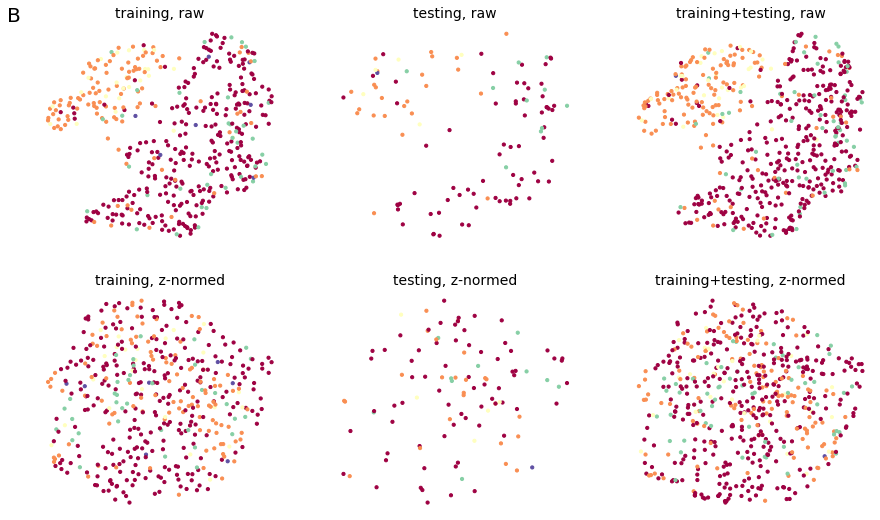

In [24]:
# PRE POST NORMALIZATION BY CT machine

fig, axs = plt.subplots(2,3,figsize=(15,9))
axs[0,0] = cs_umap_plot.points(mapper_raw, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[0,0])
axs[0,0].set_title('training, raw')
plt.text(-0.12, 1.01, 'B', fontsize = 20, transform=axs[0,0].transAxes)

axs[0,1] = cs_umap_plot._matplotlib_points(rawPoints_valid, labels=features_validation['ct_grp_long'], point_size=10, show_legend=False, ax=axs[0,1])
axs[0,1].set_title('testing, raw')
axs[0,2] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['ct_grp_long'], point_size=10, show_legend=False, ax=axs[0,2])
axs[0,2].set_title('training+testing, raw')

axs[1,0] = cs_umap_plot.points(mapper_zscore, labels=features_training['ct_grp_long'], point_size=10, show_legend=False, ax=axs[1,0])
axs[1,0].set_title('training, z-normed')
axs[1,1] = cs_umap_plot._matplotlib_points(zscorePoints_valid, labels=features_validation['ct_grp_long'], point_size=10, show_legend=False, ax=axs[1,1])
axs[1,1].set_title('testing, z-normed')
axs[1,2] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['ct_grp_long'], point_size=10, show_legend=False, ax=axs[1,2])
axs[1,2].set_title('training+testing, z-normed')

for i, ax in enumerate(fig.axes):
    ax.axis('off')


plt.savefig(fn_f_umap_norm2, bbox_inches='tight')

Text(-0.12, 0.3, 'Prenormalization')

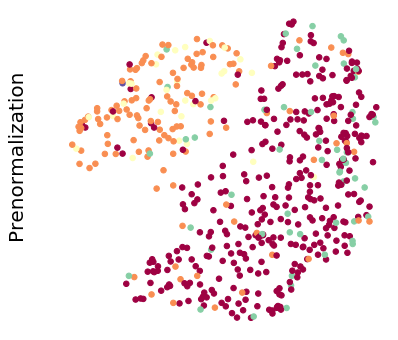

In [25]:
# for friday seminar
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['ct_grp'], point_size=30, show_legend=False, ax=axs)
axs.axis('off')
axs.set_title('')

plt.text(-0.12, 0.3, 'Prenormalization', fontsize = 20, horizontalalignment='center',
         transform=axs.transAxes, rotation='vertical')


Text(-0.12, 0.25, 'Postnormalization')

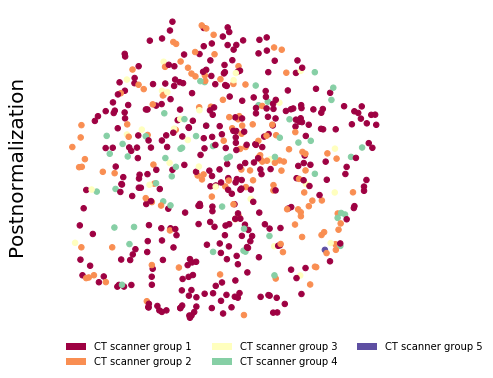

In [26]:
# for friday seminar
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['ct_grp_long'], point_size=30, show_legend=True, ax=axs)
axs.axis('off')
plt.text(-0.12, 0.25, 'Postnormalization', fontsize = 20, horizontalalignment='center',
         transform=axs.transAxes, rotation='vertical')

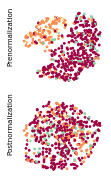

In [27]:
# for graphical abstract
fig, axs = plt.subplots(2,1,figsize=(1.5,3))

axs[0] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['ct_grp'], point_size=3, show_legend=False, ax=axs[0])
axs[0].axis('off')

plt.text(-0.12, 0.25, 'Prenormalization', fontsize = 7, horizontalalignment='center',
         transform=axs[0].transAxes, rotation='vertical')

axs[1] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['ct_grp_long'], point_size=3, show_legend=False, ax=axs[1])
axs[1].axis('off')
plt.text(-0.12, 0.25, 'Postnormalization', fontsize = 7, horizontalalignment='center',
         transform=axs[1].transAxes, rotation='vertical')


plt.savefig(fn_f_umap_thumb, bbox_inches='tight')

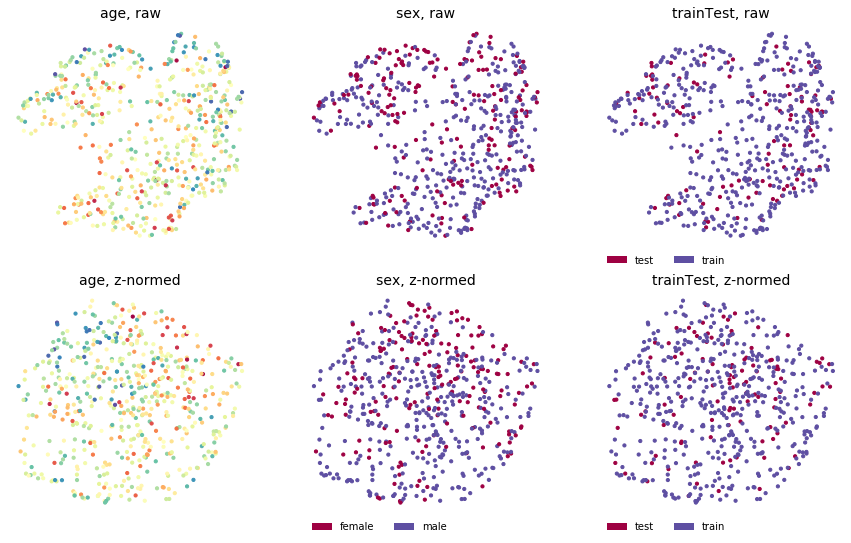

In [28]:
# PRE POST NORMALIZATION BY CT machine

fig, axs = plt.subplots(2,3,figsize=(15,9))
axs[0,0] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['age'], point_size=10, show_legend=False, ax=axs[0,0])
axs[0,0].set_title('age, raw')
axs[0,1] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['sex'], point_size=10, show_legend=False, ax=axs[0,1])
axs[0,1].set_title('sex, raw')
axs[0,2] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=features_together['trainTest'], point_size=10, show_legend=True, ax=axs[0,2])
axs[0,2].set_title('trainTest, raw')

axs[1,0] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['age'], point_size=10, show_legend=False, ax=axs[1,0])
axs[1,0].set_title('age, z-normed')
axs[1,1] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['sex'], point_size=10, show_legend=True, ax=axs[1,1])
axs[1,1].set_title('sex, z-normed')
axs[1,2] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=features_together['trainTest'], point_size=10, show_legend=True, ax=axs[1,2])
axs[1,2].set_title('trainTest, z-normed')

for i, ax in enumerate(fig.axes):
    ax.axis('off')

plt.savefig(fn_f_umap_batch1, bbox_inches='tight')

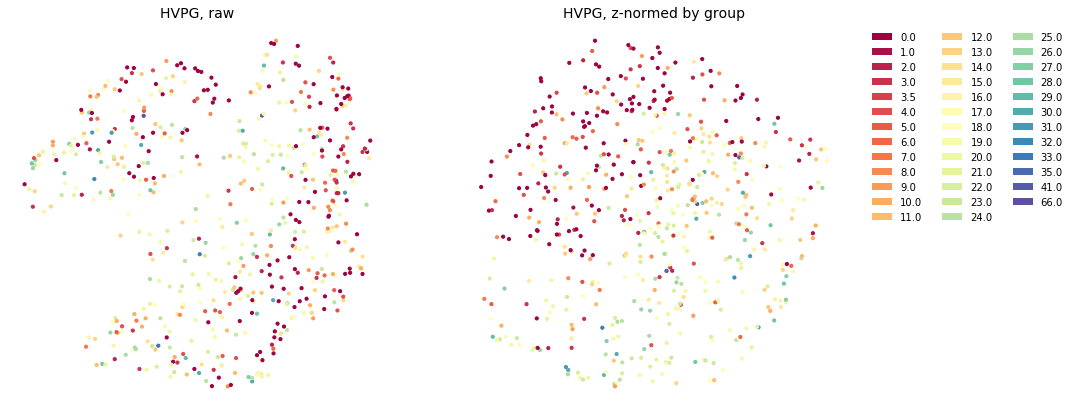

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,7))
#fig, axs = plt.subplots(2,3,figsize=(15,9))
axs[0] = cs_umap_plot._matplotlib_points(rawPoints_together, labels=np.nan_to_num(features_together['hvpg_corrected']), point_size=10, show_legend=False, ax=axs[0])
axs[0].set_title('HVPG, raw')
axs[1] = cs_umap_plot._matplotlib_points(zscorePoints_together, labels=np.nan_to_num(features_together['hvpg_corrected']), point_size=10, show_legend=True, ax=axs[1], legend_pos='rightOutside')
axs[1].set_title('HVPG, z-normed by group')

for i, ax in enumerate(fig.axes):
    ax.axis('off')
    
plt.savefig(fn_f_umap_batch2, bbox_inches='tight')

In [ ]:
allPatients_df

In [31]:
# datastructure for saving
toSave = {
    'df_rawFeatures_training': df_rawFeatures_train,
    'df_rawFeatures_validation': df_rawFeatures_validation,
    'dict_normalizationFactors': dict_normFactors,
    'df_zscoreFeatures_training': df_zscoreFeatureByGrp,
    'df_zscoreFeatures_validation': df_zscoreFeatureByGrp_validation,
    'df_metadata': allPatients_df,
    'umap_raw': mapper_raw,
    'umap_zscore': mapper_zscore}

with open(fn_finalSave, 'wb') as handle:
    pickle.dump(toSave, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(fn_finalSave_supp, 'wb') as handle:
    pickle.dump(toSave, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
df_raw_all = pd.concat([df_rawFeatures_train, df_rawFeatures_validation])
df_raw_all.to_csv(fn_rawFeat_csv)
df_raw_all.to_csv(fn_rawFeat_csv_supp)

allPatients_df.to_csv(fn_metadata_supp)

In [33]:
print(datetime.datetime.now())

2023-08-08 13:21:15.467348
